<a href="https://colab.research.google.com/github/guanjiew/csc412_vae/blob/main/ControlVAE_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is adapted from [the original ControlVAE repository](https://github.com/shj1987/ControlVAE-ICML2020/tree/master/Language_modeling/Text_gen_PTB)

# Preparation

In [1]:
%pip install texar-pytorch

     |████████████████████████████████| 440kB 19.1MB/s 
     |████████████████████████████████| 1.1MB 44.6MB/s 


In [2]:
import math, os, random
from collections import Counter
from typing import Any, Dict, Optional, Tuple, Union
random.seed(42)

import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions.categorical import Categorical
from torch.optim.lr_scheduler import ExponentialLR
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

import texar.torch as tx
from texar.torch.custom import MultivariateNormalDiag
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# VAE Model

In [3]:
def dim_kl_divergence(means: Tensor, logvars: Tensor) -> Tensor:
    """Compute the KL divergence between Gaussian distribution
    """
    kl_cost = -0.5 * (logvars - means ** 2 -
                      torch.exp(logvars) + 1.0)
    kl_cost = torch.mean(kl_cost, 0)
    return kl_cost

def kl_divergence(means: Tensor, logvars: Tensor) -> Tensor:
    return torch.sum(dim_kl_divergence(means, logvars))

In [4]:
class VAE(nn.Module):

    def __init__(self, config_model, vocab_size, padding_idx):
        super().__init__()
        # Model architecture
        self._config = config_model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self._config.embed_dim,
            padding_idx=padding_idx
        ).to(self.device)

        self.enc_dropout_in = nn.Dropout(self._config.enc_dropout_in).to(self.device)
        
        self.encoder = nn.LSTM(
            input_size=self._config.embed_dim,
            hidden_size=self._config.hidden_size,
            batch_first=True
        ).to(self.device)

        self.enc_dropout_out = nn.Dropout(self._config.enc_dropout_out).to(self.device)

        self.connector_mlp = nn.Linear(
            in_features=self._config.hidden_size * 2,
            out_features=self._config.latent_dims * 2
        ).to(self.device)

        self.mlp_linear_layer = nn.Linear(
            in_features=self._config.latent_dims,
            out_features=self._config.hidden_size * 2
        ).to(self.device)

        self.dec_dropout_in = nn.Dropout(self._config.dec_dropout_in).to(self.device)

        lstm_input = self._config.embed_dim
        logits_input = self._config.hidden_size
        if self._config.skip_connection:
            lstm_input += self._config.latent_dims
            logits_input += self._config.latent_dims

        self.decoder = nn.LSTM(
            input_size=lstm_input,
            hidden_size=self._config.hidden_size,
            batch_first=True
        ).to(self.device)

        self.dec_dropout_out = nn.Dropout(self._config.dec_dropout_out).to(self.device)

        self.logits_layer = nn.Linear(
            in_features=logits_input,
            out_features=vocab_size
        ).to(self.device)
    
    def init_state(self, batch_size=1):
        return (
            torch.zeros(1, batch_size, self._config.hidden_size).to(self.device),
            torch.zeros(1, batch_size, self._config.hidden_size).to(self.device)
        )

    def encode(self, x, seq_lengths):
        emb = self.enc_dropout_in(self.embedding(x))
        emb = torch.nn.utils.rnn.pack_padded_sequence(emb, seq_lengths, batch_first=True, enforce_sorted=False) # https://towardsdatascience.com/61d35642972e
        _, state = self.encoder(emb, self.init_state(x.size()[0]))
        state = self.enc_dropout_out(torch.cat(state, dim=-1)[0])
        mean_logvar = self.connector_mlp(state)
        mean, logvar = torch.chunk(mean_logvar, 2, 1)
        return mean, logvar
    
    def decode(self, z, x, seq_lengths, prev_state=None):
        if prev_state is None:
            prev_state = torch.chunk(self.mlp_linear_layer(z).unsqueeze(0), 2, -1)
        emb = self.dec_dropout_in(self.embedding(x))
        if self._config.skip_connection:
            z_seq = torch.cat([z.unsqueeze(1) for _ in range(emb.size()[1])], dim=1)
            emb = torch.cat((emb, z_seq), dim=-1)
        emb = torch.nn.utils.rnn.pack_padded_sequence(emb, seq_lengths, batch_first=True, enforce_sorted=False) # https://towardsdatascience.com/61d35642972e
        outputs, state = self.decoder(emb, prev_state)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        outputs = self.dec_dropout_out(outputs)
        if self._config.skip_connection:
            z_seq = torch.cat([z.unsqueeze(1) for _ in range(outputs.size()[1])], dim=1)
            outputs = torch.cat((outputs, z_seq), dim=-1)
        logits = self.logits_layer(outputs)
        return logits, state
    

# PID Control

In [5]:
class PIDControl():
    """docstring for ClassName"""
    def __init__(self):
        """define them out of loop"""
        # self.exp_KL = exp_KL
        self.I_k1 = 0.0
        self.W_k1 = 0.0
        self.e_k1 = 0.0
        
    def _Kp_fun(self, Err, scale=1):
        return 1.0/(1.0 + float(scale)*math.exp(Err))
        

    def pid(self, exp_KL, kl_loss, Kp=0.001, Ki=-0.001, Kd=0.01):
        """
        position PID algorithm
        Input: KL_loss
        return: weight for KL loss, beta
        """
        error_k = exp_KL - kl_loss
        ## comput U as the control factor
        Pk = Kp * self._Kp_fun(error_k)
        Ik = self.I_k1 + Ki * error_k

        ## window up for integrator
        if self.W_k1 < 0 and self.W_k1 > 1:
            Ik = self.I_k1
            
        Wk = Pk + Ik
        self.W_k1 = Wk
        self.I_k1 = Ik
        self.e_k1 = error_k
        
        ## min and max value
        if Wk > 1:
            Wk = 1.0
        if Wk < 0:
            Wk = 0.0
        
        return Wk
    

# Hyperparameters

In [6]:
class Config():
  dataset_size = 8750
  num_epochs = 100
  hidden_size = 256
  dec_dropout_in = 0.5
  dec_dropout_out = 0.5
  enc_dropout_in = 0.
  enc_dropout_out = 0.
  batch_size = 32
  embed_dim = 256
  latent_dims = 32
  max_vocab = 12000

  pid_control = True
  skip_connection = True

  lr_decay_hparams = {
      "init_lr": 0.001,
      "threshold": 2,
      "decay_factor": 0.5,
      "max_decay": 5
  }

  # KL annealing
  kl_anneal_hparams = {
      "warm_up": 10,
      "start": 0.1
  }

  initializer_hparams = {
      'mean': 0.0,
      'std': embed_dim**-0.5,
  }

  opt_hparams = {
      'optimizer': {
          'type': 'Adam',
          'kwargs': {
              'lr': 0.001
          }
      },
      'gradient_clip': {
          "type": "clip_grad_norm_",
          "kwargs": {
              "max_norm": 5,
              "norm_type": 2
          }
      }
  }

In [7]:
config = Config()

# Loading the dataset

In [8]:
url = 'https://raw.githubusercontent.com/rekiksab/Yelp-Data-Challenge-2013/master/yelp_challenge/yelp_phoenix_academic_dataset/yelp_academic_dataset_review.json'
data = pd.read_json(url, lines=True)
data = data.loc[:,['text','stars']]

tokenizer = get_tokenizer('basic_english')
data.loc[:,'text'] = data.loc[:,'text'].map(lambda s: ['<BOS>']+tokenizer(s)+['<EOS>','<PAD>'])

counter = Counter()
for line in data.loc[:,'text'].values:
    counter.update(line)
vocab = Vocab(counter, max_size=config.max_vocab)
vocab.bos_index = vocab['<BOS>']
vocab.eos_index = vocab['<EOS>']
vocab.padding_index = vocab['<PAD>']

data.loc[:,'text'] = data.loc[:,'text'].map(lambda s: [vocab[token] for token in s[:-1]])

In [9]:
data_pairs = [(pair[0], pair[1]) for pair in data.loc[:,['text','stars']].values]
if len(data_pairs) > config.dataset_size:
    data_pairs = random.sample(data_pairs, config.dataset_size)

random.shuffle(data_pairs)
valid_len = round(0.15 * len(data_pairs))
valid_data, test_data, train_data = data_pairs[:valid_len], data_pairs[valid_len:2*valid_len], data_pairs[2*valid_len:]

In [10]:
def get_padded_batches(data, batch_size, padding_index):
    batches = []
    seq_lengths = []
    for k in range(batch_size, len(data), batch_size):
        batch = [pair[0] for pair in data[k-batch_size:k]]
        lengths = [len(text) for text in batch]
        padded_length = max(lengths)
        for text in batch:
            while len(text) < padded_length:
                text.append(padding_index)
        batches.append(torch.tensor(batch))
        seq_lengths.append(torch.tensor(lengths))
    return batches, seq_lengths

train_batches, train_lengths = get_padded_batches(train_data, config.batch_size, vocab.padding_index)
valid_batches, valid_lengths = get_padded_batches(valid_data, config.batch_size, vocab.padding_index)
test_batches, test_lengths = get_padded_batches(test_data, config.batch_size, vocab.padding_index)

In [11]:
dataset = {
    "train": list(zip(train_batches, train_lengths)),
    "valid": list(zip(valid_batches, valid_lengths)),
    "test": list(zip(test_batches, test_lengths))
}

# Training the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

opt_vars = {
    'learning_rate': config.lr_decay_hparams["init_lr"],
    'best_valid_nll': 1e100,
    'steps_not_improved': 0,
    'kl_weight': 1.0
}

decay_cnt = 0
max_decay = config.lr_decay_hparams["max_decay"]
decay_factor = config.lr_decay_hparams["decay_factor"]
decay_ts = config.lr_decay_hparams["threshold"]

save_path = './checkpoint.ckpt'

model = VAE(config, len(vocab.itos), vocab.padding_index)

optimizer = tx.core.get_optimizer(
    params=model.parameters(),
    hparams=config.opt_hparams)
scheduler = ExponentialLR(optimizer, decay_factor)

max_iter = min(config.num_epochs*len(train_data)/config.batch_size, 80000)
print('max steps:', max_iter)

global_steps = {}
global_steps['step'] = 0
pid = PIDControl()
opt_vars["kl_weight"] = 1.0
Kp = 0.01
Ki = -0.0001
exp_kl = 0

max steps: 19143.75


In [ ]:
def _run_epoch(epoch: int, mode: str, display: int = 10) -> Tuple[Tensor, float]:
    if mode == 'train':
        model.train()
        kl_weight = opt_vars["kl_weight"]
    else:
        model.eval()
        kl_weight = 1.0
    
    num_words = 0
    nll_total = 0.

    avg_rec = tx.utils.AverageRecorder()
    for batch, seq_lengths in dataset[mode]:
        if global_steps['step']>= max_iter:
            break
        mean, logvar = model.encode(batch.to(model.device), seq_lengths)
        dst = MultivariateNormalDiag(loc=mean, scale_diag=torch.exp(0.5 * logvar))
        z = dst.sample()
        logits, _ = model.decode(mean, batch[:,:-1].to(model.device), seq_lengths-1)
        rec_loss = tx.losses.sequence_sparse_softmax_cross_entropy(labels=batch[:,1:].to(model.device), logits=logits, sequence_length=(seq_lengths-1).to(model.device))
        kl_loss = kl_divergence(mean, logvar)
        total_loss = rec_loss + kl_weight * kl_loss
        if mode == "train":
            pbar.update(1)
            global_steps['step'] += 1
            if config.pid_control:
                kl_weight = pid.pid(exp_kl, kl_loss.item(), Kp, Ki)
                opt_vars["kl_weight"] = kl_weight
            ## total loss
            total_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        batch_size = len(batch)
        num_words += torch.sum(seq_lengths).item()
        nll_total += total_loss.item() * batch_size
        avg_rec.add(
            [total_loss.item(),
              kl_loss.item(),
              rec_loss.item()],
            batch_size)
            
        if global_steps['step'] % display == 1 and mode == 'train':
            nll = avg_rec.avg(0)
            klw = opt_vars["kl_weight"]
            KL = avg_rec.avg(1)
            rc = avg_rec.avg(2)
            
    nll = avg_rec.avg(0)
    KL = avg_rec.avg(1)
    rc = avg_rec.avg(2)
    if num_words > 0:
        log_ppl = nll_total / num_words
        ppl = math.exp(log_ppl)
    else:
        log_ppl = 100
        ppl = math.exp(log_ppl)
        nll = 1000
        KL = args.exp_kl
    
    print(f"\n{mode}: epoch {epoch}, nll {nll:.4f}, KL {KL:.4f}, "
          f"rc {rc:.4f}, log_ppl {log_ppl:.4f}, ppl {ppl:.4f}")
    return nll, ppl  # type: ignore

In [ ]:
# Counts trainable parameters
total_parameters = sum(param.numel() for param in model.parameters())
print(f"{total_parameters} total parameters")

best_nll = best_ppl = 0.

## start running model
pbar = tqdm(total = int(max_iter))
train_losses, val_losses = [], []
beta = []
for epoch in range(config.num_epochs):
    train_nll, _ = _run_epoch(epoch, 'train', display=200)
    val_nll, _ = _run_epoch(epoch, 'valid')
    test_nll, test_ppl = _run_epoch(epoch, 'test')
    train_losses.append(train_nll)
    val_losses.append(val_nll)
    beta.append(opt_vars["kl_weight"])

    if val_nll < opt_vars['best_valid_nll']:
        opt_vars['best_valid_nll'] = val_nll
        opt_vars['steps_not_improved'] = 0
        best_nll = test_nll
        best_ppl = test_ppl

        states = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict()
        }
        torch.save(states, save_path)
    else:
        opt_vars['steps_not_improved'] += 1
        if opt_vars['steps_not_improved'] == decay_ts:
            old_lr = opt_vars['learning_rate']
            opt_vars['learning_rate'] *= decay_factor
            opt_vars['steps_not_improved'] = 0
            new_lr = opt_vars['learning_rate']
            ckpt = torch.load(save_path)
            model.load_state_dict(ckpt['model'])
            optimizer.load_state_dict(ckpt['optimizer'])
            scheduler.load_state_dict(ckpt['scheduler'])
            scheduler.step()
            print(f"-----\nchange lr, old lr: {old_lr}, "
                  f"new lr: {new_lr}\n-----")

            decay_cnt += 1
            if decay_cnt == max_decay:
                break
    if global_steps['step'] >= max_iter:
        break

print(f"\nbest testing nll: {best_nll:.4f},"
      f"best testing ppl {best_ppl:.4f}\n")


  0%|          | 0/76562 [00:00<?, ?it/s]

7259426 total parameters



  1%|          | 455/76562 [01:41<5:07:36,  4.12it/s]

KeyboardInterrupt: ignored

In [ ]:
plt.plot(train_losses, 'b-', label="Train")
plt.plot(val_losses, 'g-', label="Validation")
plt.title("ControlVAE Text Generation Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative ELBO")
plt.legend()
plt.show()

In [ ]:
plt.plot(beta)
plt.title("ControlVAE Text Generation Beta Parameter")
plt.xlabel("Epoch")
plt.ylabel("Beta")
plt.show()

# Generate text

In [12]:
# Load from checkpoint
save_path = './checkpoint.ckpt'
model = VAE(config, len(vocab.itos), vocab.padding_index)
ckpt = torch.load(save_path)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [13]:
model.eval()

batch_size = config.batch_size
'''
test_sentence = 'The service was terrible.'
tokens = ['<BOS>']+tokenizer(test_sentence)+['<EOS>']
text_ids = torch.tensor([[vocab[token] for token in tokens]])
mean, logvar = model.encode(text_ids.to(model.device), torch.tensor([len(tokens)]))
dst = MultivariateNormalDiag(loc=mean[0], scale_diag=torch.exp(0.5 * logvar[0]))
latent_z = dst.sample((batch_size,))
'''
# latent_z = torch.FloatTensor(batch_size, config.latent_dims).uniform_(-1, 1).to(model.device)
latent_z = torch.randn(batch_size, config.latent_dims).to(model.device)

gen_text = None
gen_chars = torch.tensor([[vocab.bos_index] for _ in range(batch_size)])
seq_lengths = torch.zeros(batch_size).type(torch.LongTensor)
not_done = torch.ones(batch_size).type(torch.LongTensor)
state = None
while gen_text is None or gen_text.size()[1] < 1000:
    logits, state = model.decode(latent_z.to(model.device), gen_chars.to(model.device), torch.ones(batch_size), state)
    cdst = Categorical(logits=logits)
    gen_chars = cdst.sample()
    not_done *= (gen_chars != vocab.eos_index).squeeze().type(torch.LongTensor)
    seq_lengths += not_done
    if gen_text is None:
        gen_text = gen_chars.cpu()
    else:
        gen_text = torch.cat((gen_text, gen_chars.cpu()), dim=-1)
    if torch.sum(not_done) == 0:
        break
for i,line in enumerate(gen_text):
    print(' '.join([vocab.itos[line[j]] for j in range(seq_lengths[i])]))

to any little gyms that weren ' t exactly what they don ' t only take one of it driven as it ' s hey because the staff is very nice . they ' re enjoying trying out at home but this hotel was a good variety of 17 and not <unk> . they like the same $ in a section magazine at la <unk> . overall , possibly does your new downhill - . . maybe it ' s not greasy . i guess that was around a intro vendor . i didn ' t understand how much them becomes 2 tacos , the <unk> were just stellar . so if you reach no <unk> should carry the malls your pricing here but they would not return from the merchandise . it ' s not $10 in this <unk> store place doesn ' t even putting the price of sauces in trash but not the woman into a chase .
couple pounds yelp won ' t manage for a few weeks ago at lux for the morning . no focused that had a luxury fries , eggs and mayo , still ' s paradise , didn ' t get a inability to singing on . hehe more spices , i ' m pleased off the burgers this . straight up on kitsch dis

# Mutual information

In [14]:
def mutual_information(model, dataset, N1=10000, N2=100):
    model.eval()

    kl1 = None
    z2 = None
    for batch, seq_lengths in dataset:
        mean, logvar = model.encode(batch.to(model.device), seq_lengths)
        logstd = logvar / 2
        dst = MultivariateNormalDiag(loc=mean, scale_diag=torch.exp(logstd))
        z1 = dst.sample((N1,))
        batch_z2 = torch.cat(list(dst.sample((N2,))))
        if z2 is None:
            z2 = batch_z2
        else:
            z2 = torch.cat((z2, batch_z2))
        batch_kl1 = torch.mean(torch.sum(((z1 ** 2 - ((z1 - mean) / torch.exp(logstd)) ** 2) / 2) - logstd, dim=-1), dim=0)
        if kl1 is None:
            kl1 = batch_kl1
        else:
            kl1 = torch.cat((kl1, batch_kl1))
    kl1 = torch.mean(kl1)
    
    kl2 = None
    for batch, seq_lengths in dataset:
        mean, logvar = model.encode(batch.to(model.device), seq_lengths)
        logstd = logvar / 2
        mean = mean.unsqueeze(1)
        logstd = logstd.unsqueeze(1)
        batch_kl2 = torch.mean(torch.sum(((z2 ** 2 - ((z2 - mean) / torch.exp(logstd)) ** 2) / 2) - logstd, dim=-1), dim=-1)
        if kl2 is None:
            kl2 = batch_kl2
        else:
            kl2 = torch.cat((kl2, batch_kl2))
    kl2 = torch.mean(kl2)

    return kl1 - kl2

with torch.no_grad():
    print(mutual_information(model, dataset['test']))

tensor(13.6136)


# $\epsilon$-$\delta$ collapse

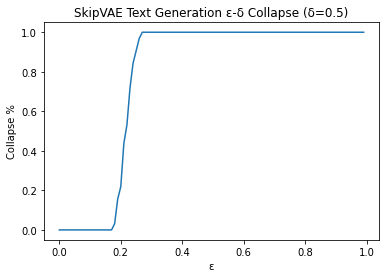

In [ ]:
def ed_collapse(model, dataset, delta):
    epsilons = torch.arange(0, 1, 0.01).to(model.device)
    epsilons_size = epsilons.size(0)
    rep_epsilons = epsilons.view(epsilons_size, 1).repeat(1, config.latent_dims)
    all_zs_lt_epsilon = torch.zeros(epsilons_size, config.latent_dims).to(model.device)

    batch_count = 0
    for batch, seq_lengths in dataset:
        batch_count += 1
        mean, logvar = model.encode(batch.to(model.device), seq_lengths)
        dim_wise_kld = dim_kl_divergence(mean, logvar)  # dim_wise_kld dim = z_dim
        zs_lt_epsilon = dim_wise_kld.repeat(epsilons_size, 1) < rep_epsilons
        all_zs_lt_epsilon += zs_lt_epsilon
    
    prop_lt_epsilon = torch.div(all_zs_lt_epsilon, batch_count)
    collapsed = prop_lt_epsilon >= delta
    prop_collapsed = torch.div(torch.sum(collapsed, dim=1), config.latent_dims)
    return epsilons, prop_collapsed

with torch.no_grad():
    delta = 0.5
    epsilons, prop_collapsed = ed_collapse(model, dataset['test'], delta)
    plt.plot(epsilons, prop_collapsed)
    plt.title("SkipVAE Text Generation ε-δ Collapse (δ=0.5)")
    plt.xlabel("ε")
    plt.ylabel("Collapse %")
    plt.show()

# tSNE

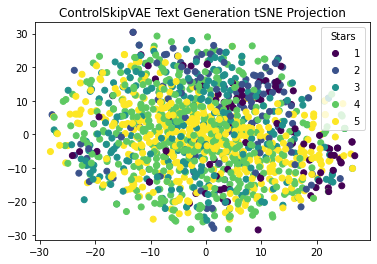

In [17]:
def tsne(model, dataset):
    latents = None
    for batch, seq_lengths in dataset:
        batch_latents, _ = model.encode(batch.to(model.device), seq_lengths)
        if latents is None:
            latents = batch_latents.cpu()
        else:
            latents = torch.cat([latents, batch_latents.cpu()])
    projections = TSNE().fit_transform(latents.numpy())
    return projections

with torch.no_grad():
    projections = tsne(model, dataset['test'])
    labels = [pair[1] for pair in test_data[:projections.shape[0]]]
    scatter = plt.scatter(projections[:,0], projections[:,1], c=labels)
    plt.title("ControlSkipVAE Text Generation tSNE Projection")
    plt.legend(*scatter.legend_elements(), title="Stars")
    plt.show()